# Compressed Sensing

In this post I’ll be investigating compressed sensing (also known as compressive sensing, compressive sampling, and sparse sampling) in Python. Since the idea of compressed sensing can be applied in wide array of subjects, I’ll be focusing mainly on how to apply it in one and two dimensions to things like sounds and images. Specifically, I will show how to take a highly incomplete data set of signal samples and reconstruct the underlying sound or image. It is a very powerful technique.

## L$^1$ vs. L$^2$ Fitting

As you might know, there are many different types of norms. Perhaps the most common and widely recognized one is the L$^2$ norm:

$∥x⃗∥_2=(∑i=0nx2i)1/2$

The L2
norm is nice because it is easily calculated, easily differentiated, and it has intuitive appeal (e.g., the norm of a vector is its length). A lot of very important algorithms and methods rely on the L2

, including least squares fitting.

That said, the L2
norm isn’t the goto solution for everything. The other norms also have many interesting and useful properties. Consider the L1

norm:

∥x⃗ ∥1=∑i=0n|xi|

Instead of squaring each element, it simply takes its absolute value. Although the absolute value is annoying in the sense that it often introduces discontinuities in its derivatives, it does have some unique properties when compared to the squaring that takes place in the L2

norm. Compressed sensing is all about exploiting these properties.

Let’s visualize some data with Python to see what I’m talking about.

In [70]:
# make sure you've got the following packages installed

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
from PIL import Image #I prefer Pillow #import imageio as iio
import cvxpy as cvx



In [71]:
# generate some data with noise
x = np.sort(np.random.uniform(0, 10, 15))
y = 3 + 0.2 * x + 0.1 * np.random.randn(len(x))

In [72]:
# find L1 line fit
l1_fit = lambda x0, x, y: np.sum(np.abs(x0[0] * x + x0[1] - y))
xopt1 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y))

# find L2 line fit
l2_fit = lambda x0, x, y: np.sum(np.power(x0[0] * x + x0[1] - y, 2))
xopt2 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y))

Optimization terminated successfully.
         Current function value: 1.213727
         Iterations: 54
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 0.153131
         Iterations: 50
         Function evaluations: 93


In [73]:
 l1_fit(xopt1, x, y)

1.2137269069653875

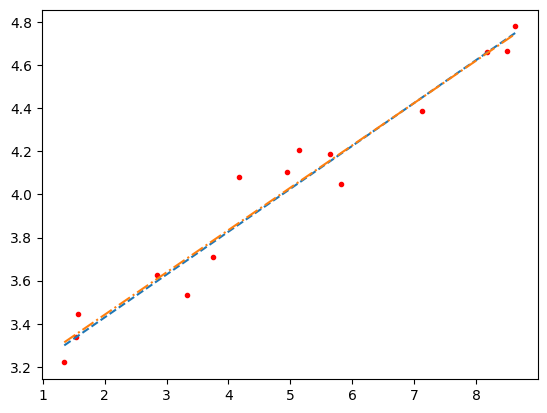

In [74]:
# Create a figure and an axes object
fig, axs = plt.subplots()
axs.plot(x, y, 'r.')
axs.plot(x, xopt1[1]+ xopt1[0] * x, '--')
axs.plot(x, xopt2[1]+ xopt2[0] * x, '-.')
plt.show()

Notice that both of the fits seem to do a pretty good job fitting the data. Sure, they don’t line up exactly, but they both are reasonable approximations given the noise.

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data, causing all kinds of headaches.

In [75]:
# adjust data by adding outlyers
y2 = y.copy()
y2[3] += 4
y2[13] -= 3

# refit the lines
xopt12 = spopt.fmin(func=l1_fit, x0=[1, 1], args=(x, y2))
xopt22 = spopt.fmin(func=l2_fit, x0=[1, 1], args=(x, y2))


Optimization terminated successfully.
         Current function value: 8.213705
         Iterations: 68
         Function evaluations: 130
Optimization terminated successfully.
         Current function value: 21.429337
         Iterations: 52
         Function evaluations: 100


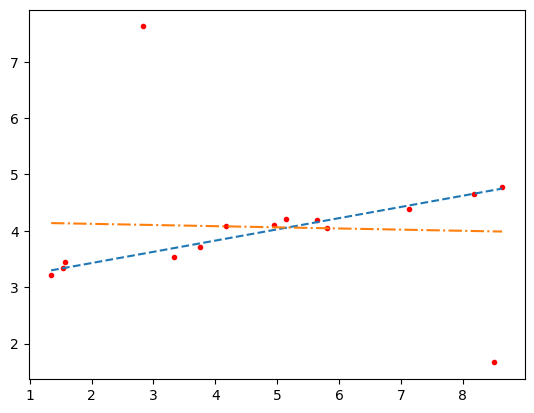

In [76]:
# Create a figure and an axes object
fig, ax = plt.subplots()
ax.plot(x, y2, 'r.')
ax.plot(x, xopt12[1]+ xopt12[0] * x, '--')
ax.plot(x, xopt22[1]+ xopt22[0] * x, '-.')

When we re-plot the L$^1$ and L$^2$ fits we see something interesting: the L$^1$ fit remained true to the overall trend in the data, while the L$^2$ fit seemed to get “corrupted” by the outliers. Why does this happen? It comes down to the fact that L$^2$ error gets squared, while L$^1$ error does not. When you fit a line to data using an L$^2$ interpretation of error, the displacement of outliers has a disproportional impact because their already-big errors are get getting squared. Just look at the distance of the two outliers in our example and imagine squaring them – of course it’s not surprising that the L$^2$ line gets skewed!

However, when using an L$^1$ interpretation of error, the outliers contribute no more than their displacement. The result is a cleaner fit that more closely matches our intuition of what a good fit should look like. It’s this interesting property that opens the door to compressed sensing.

## Reconstruction of a Simple Signal

In this example (borrowed from Kutz1), we will create an artificial sound wave, sample 10% of it, and reconstruct the original signal from the sample of 10%. This is one dimensional compressed sensing.

First, create a signal of two sinusoids.



In [77]:
# sum of two sinusoids
n = 5000
t = np.linspace(0, 1/8, n)
y = np.sin(1394 * np.pi * t) + np.sin(3266 * np.pi * t)
yt = spfft.dct(y, norm='ortho')

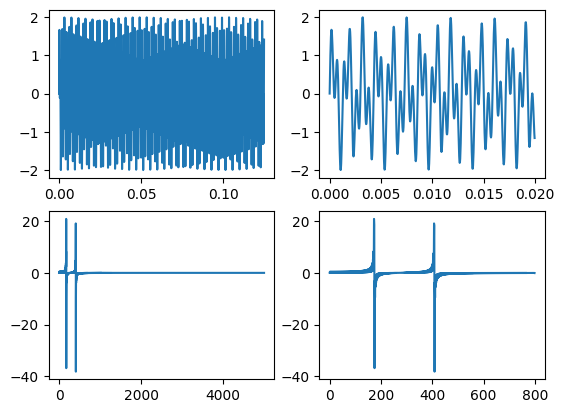

In [78]:
# Create a figure and an axes object
p=800
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].plot(t, y)
ax[0,1].plot(t[0:p], y[0:p])
ax[1,0].plot(yt)
ax[1,1].plot(yt[0:p])

In the plots above, we see that the signal has a clear pattern, yet is non-trivial. The plots in the top row are of the signal in the temporal domain at different scales. The plots in the bottom row are of the signal in the spectral domain (i.e., the signal’s frequency content). Considering the frequency domain in particular, we note that the spectrum is mostly zero except for the two spikes representing the two sine frequencies.

Now imagine sampling 10% of the temporal signal (see below). You’d have a data set that, to the naked eye, would look like nonsense. The underlying signal is would still be the same, as would be its frequency content (mostly zeros, with the exception of two spikes). One might ask if it is somehow possible to extract those two dominant frequencies from the incomplete data so that we might reconstruct the signal? The answer is yes!

In [79]:
# extract small sample of signal
m = 500 # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

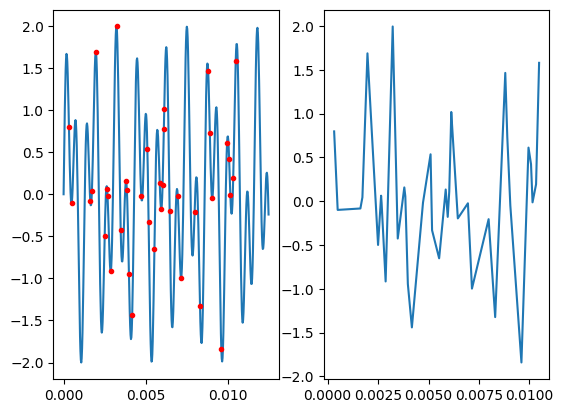

In [80]:
# Create a figure and an axes object
p=500
fig, ax = plt.subplots(ncols=2)

ax[0].plot(t[0:p], y[0:p])
p = 38
ax[0].plot(t2[0:p], y2[0:p], 'r.')
ax[1].plot(t2[0:p], y2[0:p])

In [81]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2] #sound or image. It is a very powerful technique.sound or image. It is a very powerful technique.
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 16 02:26:27 PM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 16 02:26:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 16 02:26:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 16 02:26:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 16 02:26:27 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:26:27 PM: Compiling problem (target solver=ECOS).
(C

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver expl

(CVXPY) Nov 16 02:26:28 PM: Applying reduction ECOS
(CVXPY) Nov 16 02:26:30 PM: Finished problem compilation (took 2.591e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:26:30 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:27:15 PM: Problem status: optimal
(CVXPY) Nov 16 02:27:15 PM: Optimal value: 3.198e+02
(CVXPY) Nov 16 02:27:15 PM: Compilation took 2.591e+00 seconds
(CVXPY) Nov 16 02:27:15 PM: Solver (including time spent in interface) took 4.516e+01 seconds


In [82]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == y2]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 16 02:27:16 PM: Your problem has 5000 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 16 02:27:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 16 02:27:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 16 02:27:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 16 02:27:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:27:16 PM: Compiling problem (target solver=ECOS).
(C

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver expl

(CVXPY) Nov 16 02:27:17 PM: Applying reduction ECOS
(CVXPY) Nov 16 02:27:18 PM: Finished problem compilation (took 2.598e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:27:18 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:28:05 PM: Problem status: optimal
(CVXPY) Nov 16 02:28:05 PM: Optimal value: 3.198e+02
(CVXPY) Nov 16 02:28:05 PM: Compilation took 2.598e+00 seconds
(CVXPY) Nov 16 02:28:05 PM: Solver (including time spent in interface) took 4.705e+01 seconds


In [83]:
# reconstruct signal
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

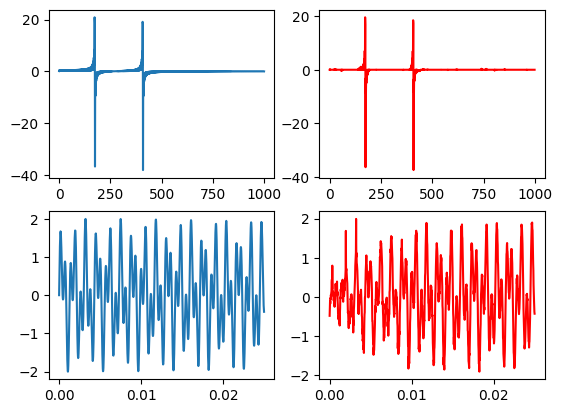

In [84]:
# Create a figure and an axes object
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].plot(yt[0:1000])
ax[0,1].plot(x[0:1000], 'r')
ax[1,0].plot(t[0:1000], y[0:1000])
ax[1,1].plot(t[0:1000], sig[0:1000], 'r')


One problem that stands out is that the quality of the reconstruction degrades noticeably at and around t=0

. This is probably due to our sample interval violating the periodic boundary condition requirements of the cosine transform. Of course, given an arbitrary signal sample without any prior knowledge of its nature, it would be hard not to violate periodic boundary conditions. The good news is that now we have some very clear indications of the true signal’s frequencies. If desired, we could go back and resample the signal within an interval that satisfies periodic boundaries.
Reconstruction of an Image (a 2D Signal)

Now let’s use what we learned from the 1-dimensional case to do compressed sensing in 2-dimensions. This is where the real fun begins because we can now try and reconstruct images.

Below, we will use exactly the same methodology as before to randomly sample and reconstruct the image Waterfall by M. C. Escher (approx. 1200 by 1600 pixels). Due to memory limitations imposed by the A

matrix, we’ll start off by considering a downsized version of the image (approx. 50 by 65 pixels). In the section that follows we’ll extend the routine to handle large images.

Note that SciPy doesn’t provide 2D versions of dct or idct. However, they can be easily constructed by recognizing that the 2D discrete cosine transform is nothing more than a dct acting upon the rows of x

followed by a second dct action upon its columns (or vice versa):

dct(dct(xT)T)≡dct(dct(x)T)T

As a personal preference, I like to tell SciPy’s dct and idct methods to act on the columns of a matrix (as opposed to the default behavior of acting on the rows). First of all, this keeps the Python code consistent with that of MATLAB. Second, it makes building matrix operators more intuitive (to me at least). For example, if we let Y
be an m by n matrix, with Im and In being identity matrices of size m and n

respectively, then

dct(Y, axis=0)≡dct(Im, axis=0)⋅Y(MATLAB default)

whereas

dct(Y, axis=1)≡Y⋅dct(In, axis=1)(SciPy default)

Either version can be made to work, but I feel like the first one is cleaner because it naturally keeps the matrix operator in front of the operand. Whenever I refer to the dct or idct, assume that I mean the axis=0 variety.

In [92]:
b.shape

(1988, 1)

In [93]:
############ WARNING! VERY SLOW! (9 mins) ###############


def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# read original image and downsize for speed
Xorig = Image.open('erscher_waterfall.jpg') # read image
Xorig = np.array(Xorig).mean(axis=2) # make image grayscale
X = spimg.zoom(Xorig, 0.2) # scipy ndimage.zoom interpolates (or compresses) an image.
ny,nx = X.shape
nx, ny# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
#b = np.expand_dims(b, axis=1) #Not nessisary because numpy arrays can't represent column vectors

# create dct matrix operator using kron (memory errors for large ny*nx) # 2D IDCT does exist but maybe this saves memory?
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron # What is phi?

# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 16 02:30:36 PM: Your problem has 3976 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 16 02:30:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 16 02:30:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 16 02:30:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 16 02:30:36 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:30:36 PM: Compiling problem (target solver=ECOS).
(C

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver expl

(CVXPY) Nov 16 02:30:45 PM: Applying reduction ECOS
(CVXPY) Nov 16 02:30:51 PM: Finished problem compilation (took 1.488e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:30:51 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:39:29 PM: Problem status: optimal
(CVXPY) Nov 16 02:39:29 PM: Optimal value: 1.108e+05
(CVXPY) Nov 16 02:39:29 PM: Compilation took 1.488e+01 seconds
(CVXPY) Nov 16 02:39:29 PM: Solver (including time spent in interface) took 5.186e+02 seconds


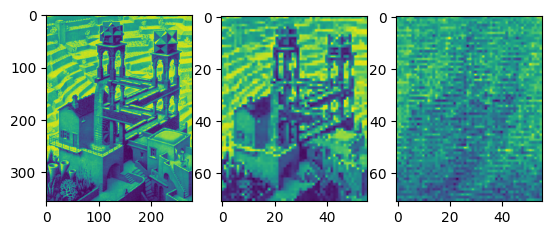

In [143]:
# Create a figure and an axes object
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(Xorig)
ax[1].imshow(X)
#ax[2].imshow(Xa) #Xa doesn't exist? What is supposed to be here?
ax[2].imshow(np.reshape(spfft.idct(Xat2), X.shape))


In [101]:
############ WARNING! VERY SLOW! (8 mins) ###############

# extract small sample of signal
k = round(nx * ny * 0.5) # 50% sample
ri = np.random.choice(nx * ny, k, replace=False) # random sample of indices
b = X.T.flat[ri]
#b = np.expand_dims(b, axis=1) #Not nessisary because numpy arrays can't represent column vectors

# create dct matrix operator using kron (memory errors for large ny*nx)
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[ri,:] # same as phi times kron

# do L1 optimization
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b] #A is the subsampled DCT idenity matrix. vx 
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Xat2 = np.array(vx.value).squeeze()

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Nov 16 02:44:46 PM: Your problem has 3976 variables, 1 constraints, and 0 parameters.
(CVXPY) Nov 16 02:44:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 16 02:44:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 16 02:44:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 16 02:44:46 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:44:46 PM: Compiling problem (target solver=ECOS).
(C

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\expressions\expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 8 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver expl

(CVXPY) Nov 16 02:44:52 PM: Applying reduction ECOS
(CVXPY) Nov 16 02:44:57 PM: Finished problem compilation (took 1.108e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:44:57 PM: Invoking solver ECOS  to obtain a solution.
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Nov 16 02:52:52 PM: Problem status: optimal
(CVXPY) Nov 16 02:52:52 PM: Optimal value: 1.137e+05
(CVXPY) Nov 16 02:52:52 PM: Compilation took 1.108e+01 seconds
(CVXPY) Nov 16 02:52:52 PM: Solver (including time spent in interface) took 4.747e+02 seconds
